In this notebook, we will try a bunch of different recommendation systems trained on open-source Amazon data. The models trained and evaluated here only utilize information about users, items and explicit feedback but can serve as good baselines or 1st level models. The algorithms applied are as follows:

- Popularity-based model
- itemKNN
- ALS
- SVD

In [55]:
# !pip install -U datasets==3.6.0 --quiet

In [56]:
# !pip install replay-rec --quiet

In [57]:
# !pip install implicit --quiet

In [4]:
from datasets import load_dataset

from replay.metrics import HitRate, NDCG, Coverage, MRR, Experiment
from replay.preprocessing.filters import LowRatingFilter
from replay.splitters import TimeSplitter
import implicit
from implicit.nearest_neighbours import ItemItemRecommender, CosineRecommender
from implicit.als import AlternatingLeastSquares
from scipy.sparse import csr_matrix
import scipy.sparse as sparse
import scipy
from sklearn.decomposition import TruncatedSVD

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023",
                       "0core_rating_only_Musical_Instruments",
                       trust_remote_code=True)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

Amazon-Reviews-2023.py: 0.00B [00:00, ?B/s]

Musical_Instruments.csv:   0%|          | 0.00/173M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

In [6]:
df = dataset['full'].to_pandas()

In [7]:
df.head(8)

,user_id,parent_asin,rating,timestamp
0,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B003LPTAYI,5.0,1452650586000
1,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B0040FJ27S,4.0,1384912482000
2,AGCI7FAH4GL5FI65HYLKWTMFZ2CQ,B06XP6TDVY,3.0,1558567365290
3,AEM663T6XHZFWLODF4US2RCOCUSA,B00WJ3HL5I,3.0,1607055693671
4,AFJTRBXMURLHS5EGNXLUHDHIZRFQ,B07T9NM5QR,5.0,1622595785255
5,AEFKF6R2GUSK2AWPSWRR4ZO36JVQ,B00A2DBHMA,5.0,1546556517459
6,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,B0C5D8X3JT,5.0,1586394628934
7,AFWHJ6O3PV4JC7PVOJH6CPULO2KQ,B07Z9M4RS1,5.0,1586394792148


In [8]:
df.rename(columns={'parent_asin': 'item_id'}, inplace=True)

In [9]:
USER_COL = 'user_id'
ITEM_COL = 'item_id'
RATING_COL = 'rating'
TIMESTAMP = 'timestamp'

In [10]:
df[RATING_COL] = df[RATING_COL].astype(float)

In [11]:
# Check for NaNs
df.isna().sum()

,0
user_id,0
item_id,0
rating,0
timestamp,0


In [12]:
# Check for duplicates
duplicates = df.duplicated(subset=['user_id', 'item_id'], keep=False)
num_duplicates = duplicates.sum()
print(f"Found {num_duplicates} duplicate user-item pairs")

Found 0 duplicate user-item pairs


### Conduct basic EDA

In [13]:
print(f'Unique users: {df[USER_COL].nunique()}')
print(f'Unique items: {df[ITEM_COL].nunique()}')

Unique users: 1762679
Unique items: 213571


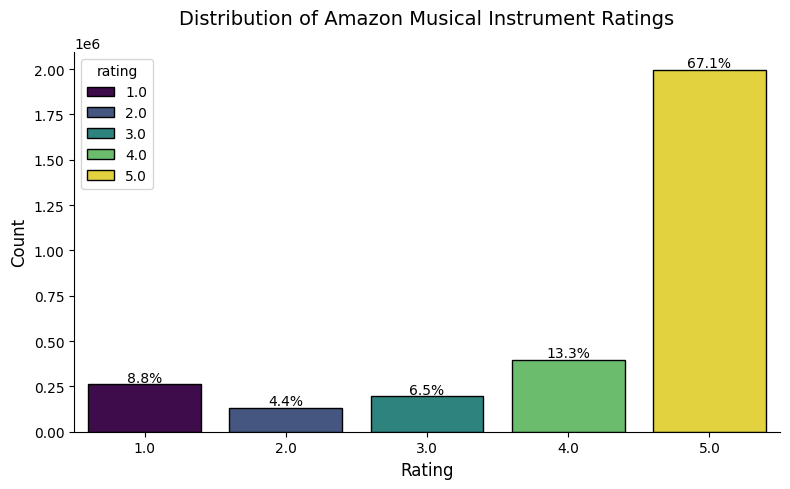

In [14]:
plt.figure(figsize=(8, 5))
plt.rcParams['figure.dpi'] = 600
ax = sns.countplot(data=df, x="rating", hue="rating",
                   palette="viridis",
                   edgecolor="black",
                   linewidth=1)

plt.title("Distribution of Amazon Musical Instrument Ratings", fontsize=14, pad=20)
plt.xlabel("Rating", fontsize=12)
plt.ylabel("Count", fontsize=12)

# plot percentage values above bars
total = len(df)
for p in ax.patches:
    height = p.get_height()
    if height == 0:
        continue
    percentage = 100 * p.get_height()/total
    ax.annotate(f'{percentage:.1f}%',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 5),
                textcoords='offset points')

sns.despine()
plt.tight_layout()
plt.show()

We can see that the majority of all ratings are positive, with 5.0 scores being the most prevalent. Ratings of 4.0 are less frequent, followed by a lower proportion of 1.0 ratings.

In [15]:
user_count = df.groupby('user_id')['item_id'].count()

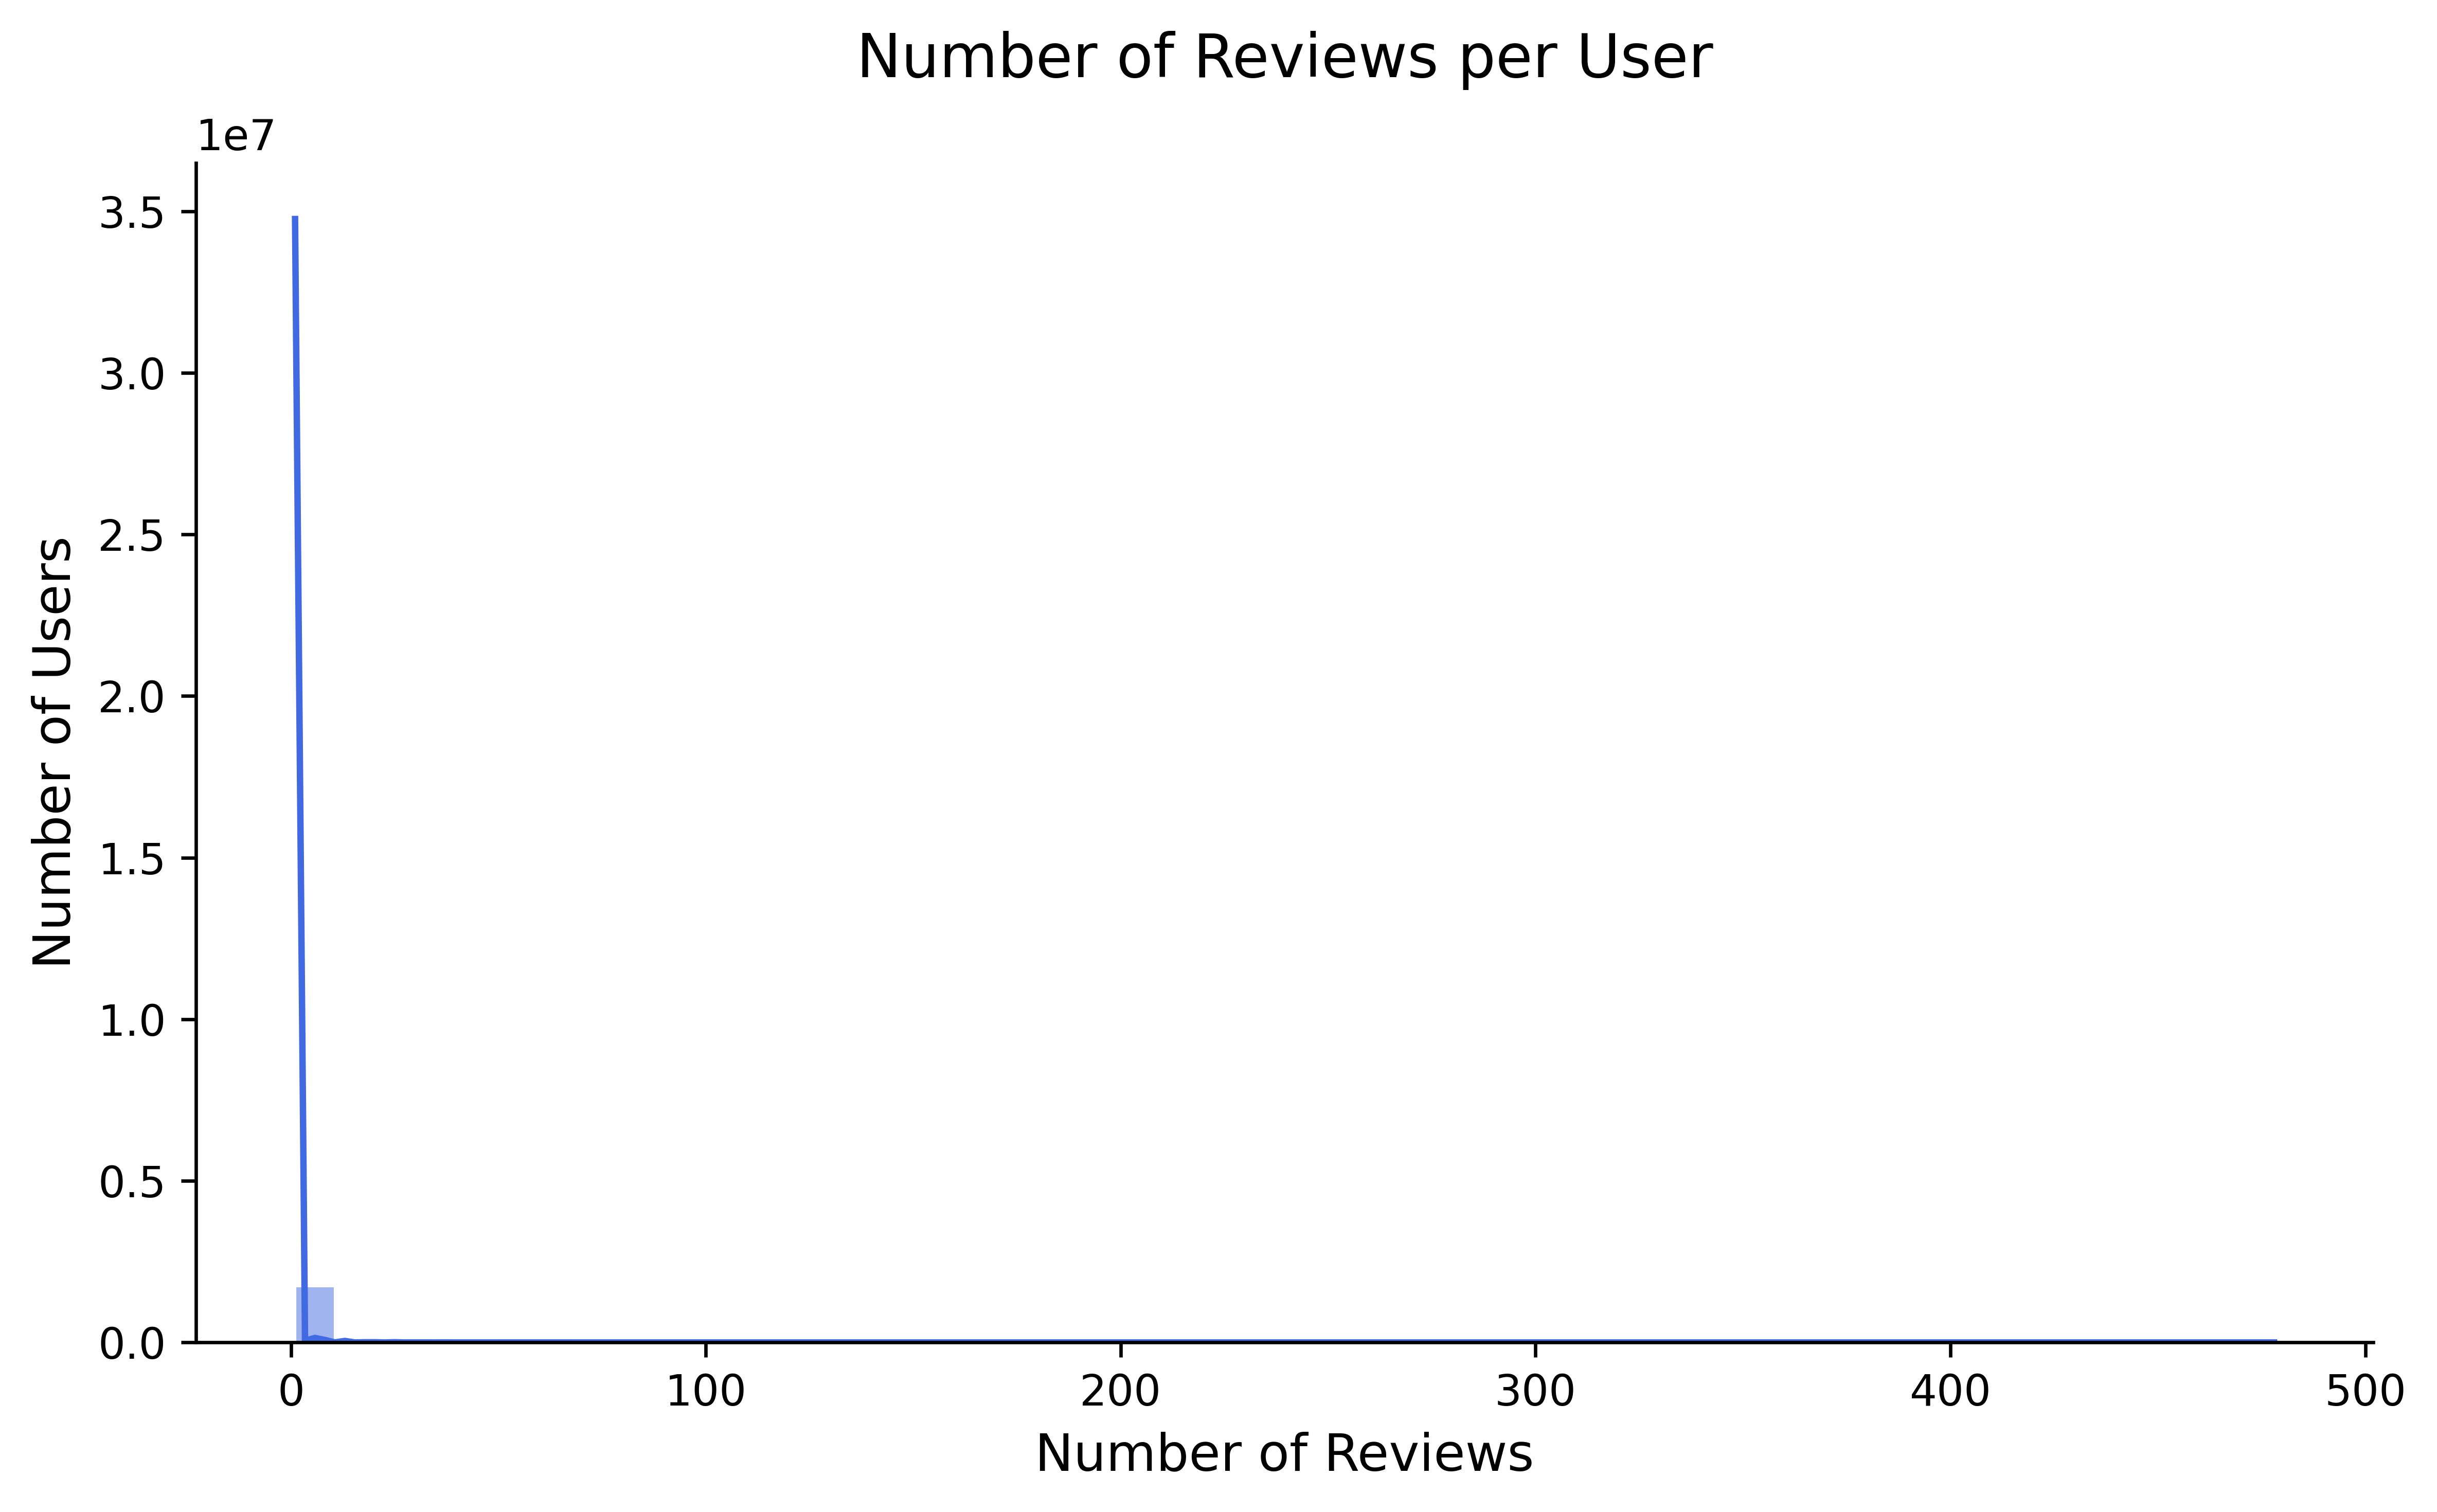

In [16]:
plt.figure(figsize=(8, 5))
plt.rcParams['figure.dpi'] = 600
ax = sns.histplot(user_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Reviews per User', fontsize=14, pad=20)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Users', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [17]:
user_count.describe()

,item_id
count,1.762679e+06
mean,1.688084e+00
std,2.564799e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,4.780000e+02


The plot and summary statistics reveal that most users rated only one or a few items. The dataset contains some super-users as well. To reduce noise and focus on meaningful patterns, we will later filter out users with few ratings.

In [18]:
item_count = df.groupby('item_id')['user_id'].count()

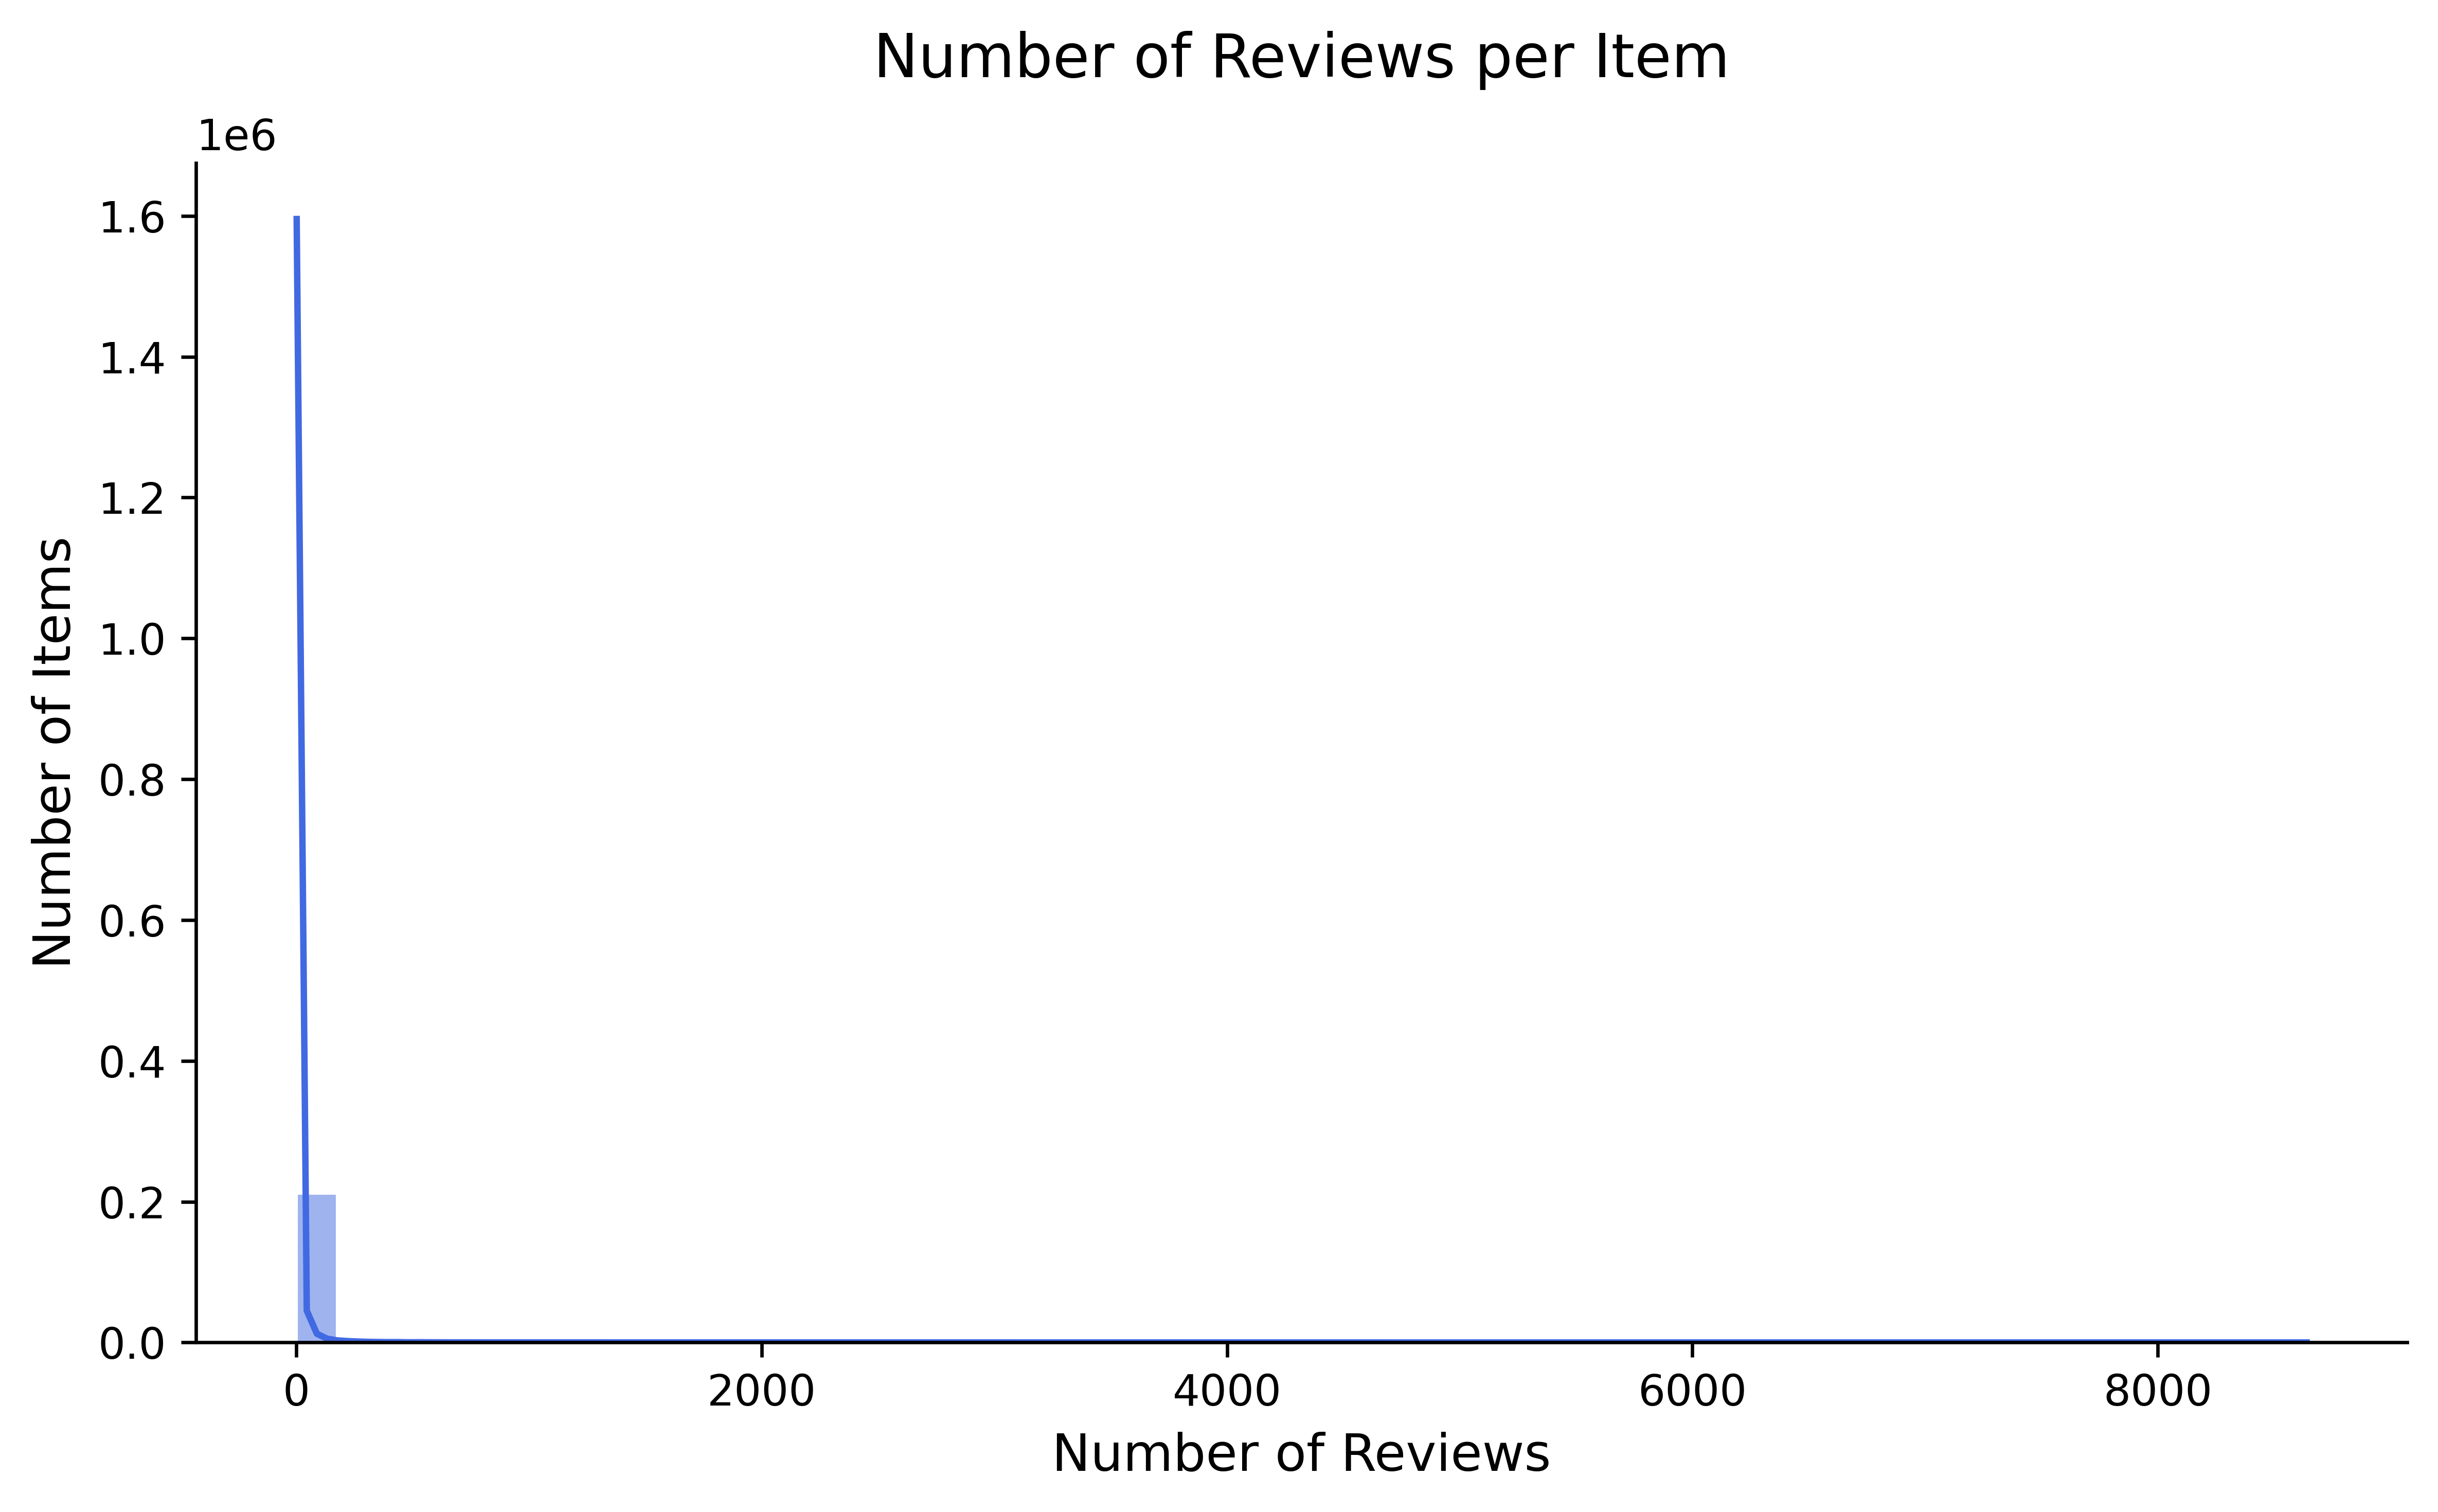

In [19]:
plt.figure(figsize=(8, 5))
plt.rcParams['figure.dpi'] = 600
ax = sns.histplot(item_count,
                 bins=50,
                 color='royalblue',
                 kde=True,
                 edgecolor='white',
                 linewidth=0.5)

plt.title('Number of Reviews per Item', fontsize=14, pad=20)
plt.xlabel('Number of Reviews', fontsize=12)
plt.ylabel('Number of Items', fontsize=12)

sns.despine()
plt.tight_layout()
plt.show()

In [20]:
item_count.describe()

,user_id
count,213571.000000
mean,13.932374
std,83.831986
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,8640.000000


The plot and summary statistics look similar for items.

Let's filter out users with fewer than 10 reviews and items with fewer than 20 reviews.

In [21]:
def filter_items(df, user_col, item_col, item_min_count=20, user_min_count=10):

    print('Filtering items..')

    item_count = df.groupby(item_col)[user_col].nunique()
    item_ids = item_count[item_count >= item_min_count].index
    print(f'Number of items before: {len(item_count)}')
    print(f'Number of items after: {len(item_ids)}')

    user_count = df.groupby(user_col)[item_col].nunique()
    user_ids = user_count[user_count >= user_min_count].index
    print(f'Number of users before: {len(user_count)}')
    print(f'Number of users after: {len(user_ids)}')

    print(f'Interactions length before: {len(df)}')
    df = df[df[item_col].isin(item_ids)&df[user_col].isin(user_ids)]
    df.reset_index(inplace=True, drop=True)
    print(f'Interactions length after: {len(df)}')

    return df

In [22]:
df = filter_items(df, USER_COL, ITEM_COL, 20, 10)

Filtering items..
Number of items before: 213571
Number of items after: 23594
Number of users before: 1762679
Number of users after: 22466
Interactions length before: 2975551
Interactions length after: 274284


In [23]:
df[RATING_COL].value_counts()

,count
rating,
5.0,193091
4.0,41729
3.0,18942
1.0,11233
2.0,9289


Let's split the data temporally so that 20% of interactions end up in the test set. We'll exclude cold users and cold items from the test set.

In [24]:
train, test = TimeSplitter(time_threshold=0.2,
                           query_column=USER_COL,
                           item_column=ITEM_COL,
                           drop_cold_users=True,
                           drop_cold_items=True).split(df)
train.shape, test.shape

((219427, 4), (34388, 4))

In [25]:
# sanity check
train[TIMESTAMP].max() < test[TIMESTAMP].min()

True

We will evaluate the recommendation quality only on items that received high ratings in the test set:

In [26]:
test = LowRatingFilter(value=4, rating_column=RATING_COL).transform(test)
test.shape

(28491, 4)

Assign IDs to users and items instead of string values:

In [27]:
all_users = train[USER_COL].unique().tolist()
all_items = train[ITEM_COL].unique().tolist()

n_users = train[USER_COL].nunique()
n_items = train[ITEM_COL].nunique()

user_id2idx = dict(zip(all_users, range(n_users)))
item_id2idx = dict(zip(all_items, range(n_items)))

train[USER_COL] = train[USER_COL].map(user_id2idx)
train[ITEM_COL] = train[ITEM_COL].map(item_id2idx)
test[USER_COL] = test[USER_COL].map(user_id2idx)
test[ITEM_COL] = test[ITEM_COL].map(item_id2idx)

#### Create and evaluate a simple baseline, always recommending TOP_POPULAR items:

In [28]:
TOP_POPULAR = 10

pop_items = train["item_id"].value_counts().index.values
top_k_pop_items = pop_items[:TOP_POPULAR].tolist()

In [29]:
top_k_pop_items

[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10123, 142]

In [30]:
pred = test.copy()
pred['preds'] = [top_k_pop_items] * len(pred)

In [31]:
pred.head()

,user_id,item_id,rating,timestamp,preds
244357,5110,14629,5.0,1617632621951,"[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10..."
3365,18883,18375,5.0,1617633275709,"[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10..."
205434,3106,3713,5.0,1617633303484,"[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10..."
205435,3106,5039,5.0,1617633643106,"[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10..."
183121,20852,13951,5.0,1617637871204,"[4685, 5717, 684, 91, 472, 325, 1539, 1895, 10..."


In [32]:
def evaluate_topk_metrics(pred_df, train_df, user_col, true_col, pred_col, k=10):
    """
    For each user:
      - aggregate all true items into a set
      - calculate HitRate, MRR and NDCG
    Average per-user scores across users
    Compute global coverage as fraction of unique items ever recommended.
    """
    # each user's history
    true_by_user = pred_df.groupby(user_col)[true_col].agg(lambda x: set(x)).to_dict()

    # pick one predictions list per user because the recommendations are the same
    preds_by_user = pred_df.drop_duplicates(subset=[user_col]).set_index(user_col)[pred_col].to_dict()

    all_recommended = set()

    user_metrics = []
    for user, true_items in true_by_user.items():

        preds = preds_by_user.get(user, [])
        all_recommended.update(preds)

        # HitRate
        hit = int(bool(true_items & set(preds)))

        # MRR
        ranks = [preds.index(i) + 1 for i in true_items if i in preds]
        ranks = [r for r in ranks if r <= k]
        mrr = 1.0 / min(ranks) if ranks else 0.0

        # NDCG
        dcg = sum(1.0 / np.log2(rank + 1) for rank in ranks)

        M = len(true_items)
        ideal_positions = min(M, k)
        ideal_dcg = sum(1.0 / np.log2(pos + 1) for pos in range(1, ideal_positions + 1))
        ndcg = dcg / ideal_dcg if ideal_dcg > 0 else 0.0

        user_metrics.append((hit, mrr, ndcg))

    hits, mrrs, ndcgs = zip(*user_metrics)
    hr = np.mean(hits)
    mr = np.mean(mrrs)
    nd = np.mean(ndcgs)

    # global coverage
    total_items_num = train_df[true_col].nunique()
    pred_items_num = len(all_recommended)
    coverage = pred_items_num / total_items_num

    return pd.DataFrame({
        'Metric': [f'HitRate@{k}', f'MRR@{k}', f'NDCG@{k}', f'Coverage@{k}'],
        'Value':  [hr, mr, nd, coverage]
    })

In [33]:
metrics_df = evaluate_topk_metrics(pred, train, USER_COL, ITEM_COL, 'preds', k=10)

In [34]:
new_row = metrics_df.set_index('Metric').T
new_row.index = ["Popularity-based model"]

In [35]:
new_row

Metric,HitRate@10,MRR@10,NDCG@10,Coverage@10
Popularity-based model,0.058244,0.023492,0.013228,0.000541


### Train more advanced models

Construct a sparse matrix from the train set:

In [36]:
train_csr_rating_matrix = csr_matrix(
    (train[RATING_COL].values, (train[USER_COL], train[ITEM_COL])),
    shape=(n_users, n_items)
)

In [37]:
train_csr_rating_matrix

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 219427 stored elements and shape (21138, 18496)>

A helper function to pass in a trained model and get k recommendations for a list of users:

In [38]:
def get_recs(model, test_users, interactions_sparse, k=10):
    items, values = model.recommend(
        test_users,
        interactions_sparse[test_users],
        N=k,
        filter_already_liked_items=True
        )

    recs = pd.DataFrame({
        USER_COL: test_users,
        ITEM_COL: items.tolist(),
        "score": values.tolist()
        })

    recs = recs.explode([ITEM_COL, "score"])

    return recs

Compute the following metrics:

- HitRate: proportion of held-out items appearing in the top-K
- MRR: mean reciprocal rank, emphasizes early hits
- NDCG: normalized discounted cumulative gain, accounts for rank position
- Coverage: fraction of items ever recommended across all users

In [39]:
K = [10]
metrics = Experiment(
    [
     HitRate(K),
     MRR(K),
     NDCG(K),
     Coverage(K)],
    test,
    train,
    query_column=USER_COL,
    item_column=ITEM_COL,
    rating_column="score"
)

In [40]:
TEST_USERS = test[USER_COL].unique()

Train and evaluate an itemKNN model:

In [41]:
itemKNN_model = ItemItemRecommender(K=10)
itemKNN_model.fit(train_csr_rating_matrix, show_progress=True)

  0%|          | 0/18496 [00:00<?, ?it/s]

In [42]:
recs_itemKNN = get_recs(itemKNN_model, TEST_USERS, train_csr_rating_matrix)

In [43]:
recs_itemKNN.head()

,user_id,item_id,score
0,5110,5717,9349.0
0,5110,91,5998.0
0,5110,203,5258.0
0,5110,4685,4254.0
0,5110,684,2551.0


In [44]:
metrics.add_result("itemKNN", recs_itemKNN)
metrics.results

/usr/local/lib/python3.11/dist-packages/replay/metrics/base_metric.py:80: MetricDuplicatesWarning: The recommendations contain duplicated users and items.The metrics may be higher than the actual ones.
  warnings.warn(


,HitRate@10,MRR@10,NDCG@10,Coverage@10
itemKNN,0.062784,0.027672,0.016291,0.26968


Train and evaluate an ALS model:

In [45]:
als_model = AlternatingLeastSquares(factors=50, regularization=0.1, iterations=50, use_gpu=False)
als_model.fit(train_csr_rating_matrix)

/usr/local/lib/python3.11/dist-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 2 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()


  0%|          | 0/50 [00:00<?, ?it/s]

In [46]:
recs_als = get_recs(als_model, TEST_USERS, train_csr_rating_matrix)

In [47]:
recs_als

,user_id,item_id,score
0,5110,203,0.542748
0,5110,13049,0.431753
0,5110,11817,0.352005
0,5110,5717,0.349359
0,5110,7417,0.292969
...,...,...,...
9030,19409,4727,0.167989
9030,19409,6353,0.166076
9030,19409,785,0.164851
9030,19409,978,0.154728


In [48]:
metrics.add_result("ALS", recs_als)
metrics.results

,HitRate@10,MRR@10,NDCG@10,Coverage@10
itemKNN,0.062784,0.027672,0.016291,0.269680
ALS,0.054036,0.022338,0.013813,0.031845


Train and evaluate an SVD model:

In [49]:
svd = TruncatedSVD(n_components=20, random_state=78)
user_factors = svd.fit_transform(train_csr_rating_matrix)
item_factors = svd.components_.T

In [50]:
def get_recs_svd(user_factors, item_factors, test_users, interactions_sparse, k=10):
    """
    Generate recommendations for the test set using user and item SVD factors
    """
    recs = []

    # for each user score all items by dot product, mask seen items, then pick top-k
    for u in test_users:

        scores = user_factors[u].dot(item_factors.T)

        seen = interactions_sparse[u].indices
        scores[seen] = -np.inf

        top_k_unsorted = np.argpartition(-scores, k)[:k]
        top_k = top_k_unsorted[np.argsort(-scores[top_k_unsorted])]

        for item_idx in top_k:
            recs.append({USER_COL: u, ITEM_COL: item_idx, "score": scores[item_idx]})

    return pd.DataFrame(recs)

In [51]:
recs_svd = get_recs_svd(user_factors, item_factors, TEST_USERS, train_csr_rating_matrix, k=10)

In [52]:
metrics.add_result("SVD", recs_svd)
metrics.results

,HitRate@10,MRR@10,NDCG@10,Coverage@10
itemKNN,0.062784,0.027672,0.016291,0.269680
ALS,0.054036,0.022338,0.013813,0.031845
SVD,0.047946,0.017864,0.010986,0.008326


### Let's summarize the results

In [53]:
summary_df = pd.concat([new_row, metrics.results], axis=0)

In [54]:
summary_df

,HitRate@10,MRR@10,NDCG@10,Coverage@10
Popularity-based model,0.058244,0.023492,0.013228,0.000541
itemKNN,0.062784,0.027672,0.016291,0.269680
ALS,0.054036,0.022338,0.013813,0.031845
SVD,0.047946,0.017864,0.010986,0.008326


Across all four metrics, the item–item KNN model comes out a winner. It finds more true items in the top-10 (highest HitRate, MRR, NDCG) and recommends a wider variety of items. While ALS does okay on HitRate/MRR/NDCG metrics, it covers only about 3% of items. SVD works poorly on our data. The popularity baseline earns second place on HitRate and MRR; however, its NDCG lags behind item–item KNN and ALS, and it offers zero recommendation diversity.

ItemKNN probably performs best because it can directly spot the best items due to similarity. While ALS captures general taste via latent factors, it still seems to lean toward popular items and achieves much lower coverage.